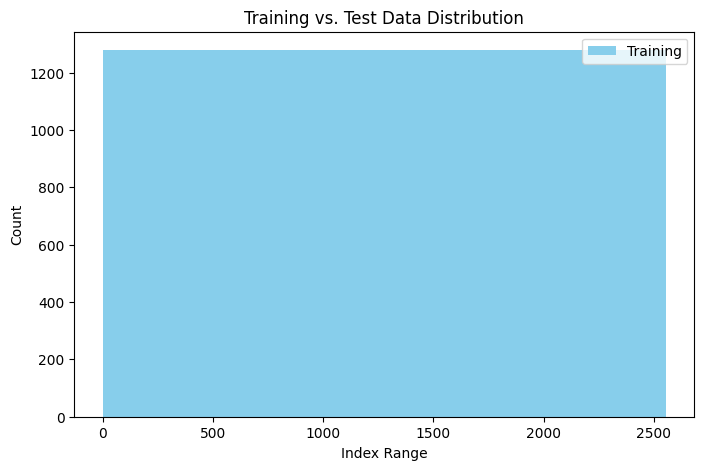

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                16896     
                                                                 
 repeat_vector_2 (RepeatVec  (None, 30, 64)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 30, 64)            33024     
                                                                 
Total params: 49920 (195.00 KB)
Trainable params: 49920 (195.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
51/51 [==============================] - 3s 32ms/step - loss: 0.1962 - val_l

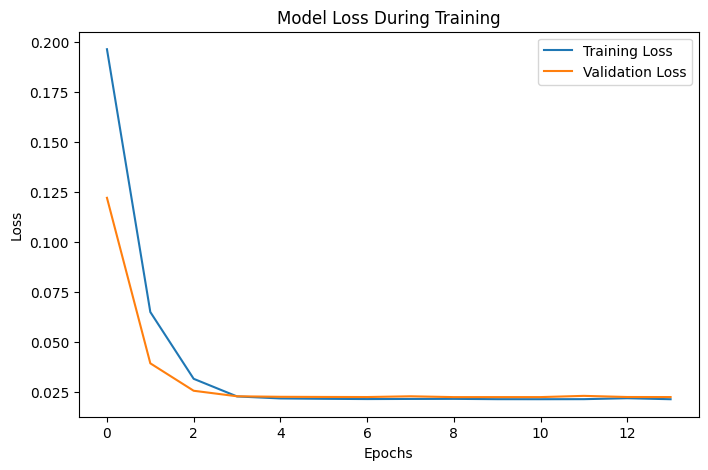

16/16 [==============================] - 0s 9ms/step
Anomaly Detection Threshold: 0.026545471514398407


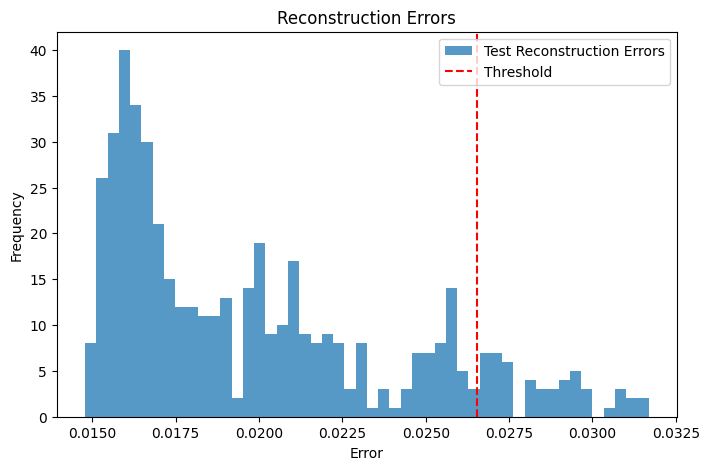

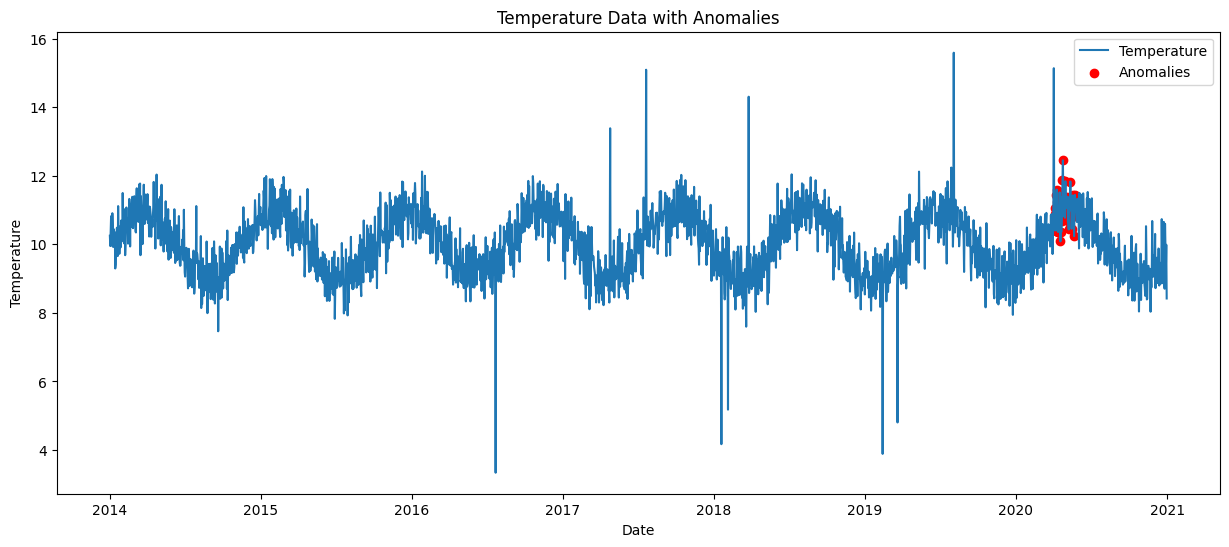

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping

file_path = 'weather_data.csv'
data = pd.read_csv(file_path)

data.columns = ['Date', 'Temperature']

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

plt.figure(figsize=(8, 5))
plt.hist(data.index, bins=2, color='skyblue', label=['Training', 'Test'])
plt.title("Training vs. Test Data Distribution")
plt.xlabel("Index Range")
plt.ylabel("Count")
plt.legend()
plt.show()

scaler = MinMaxScaler()
data['Temperature'] = scaler.fit_transform(data['Temperature'].values.reshape(-1, 1))

train_data, test_data = train_test_split(data['Temperature'].values, test_size=0.2, random_state=42, shuffle=False)

def create_sequences(data, sequence_length=30):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        sequences.append(seq)
    return np.array(sequences)

sequence_length = 30
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

train_sequences = train_sequences.reshape((train_sequences.shape[0], train_sequences.shape[1], 1))
test_sequences = test_sequences.reshape((test_sequences.shape[0], test_sequences.shape[1], 1))

input_dim = train_sequences.shape[1:]
inputs = Input(shape=input_dim)
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
latent = RepeatVector(input_dim[0])(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(latent)
outputs = decoded

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(train_sequences, train_sequences,
                          epochs=50, batch_size=32,
                          validation_split=0.2, shuffle=True,
                          callbacks=[early_stopping])

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_reconstructions = autoencoder.predict(train_sequences)
train_loss = np.mean(np.square(train_sequences - train_reconstructions), axis=(1, 2))

test_reconstructions = autoencoder.predict(test_sequences)
test_loss = np.mean(np.square(test_sequences - test_reconstructions), axis=(1, 2))

threshold = np.percentile(train_loss, 95)
print(f"Anomaly Detection Threshold: {threshold}")

anomalies = test_loss > threshold

test_dates = data['Date'][-len(test_data):].reset_index(drop=True)
valid_test_dates = test_dates[sequence_length:]
anomalous_dates = valid_test_dates[anomalies]

plt.figure(figsize=(8, 5))
plt.hist(test_loss, bins=50, alpha=0.75, label='Test Reconstruction Errors')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(data['Date'], scaler.inverse_transform(data['Temperature'].values.reshape(-1, 1)), label='Temperature')
plt.scatter(anomalous_dates, scaler.inverse_transform(test_data[sequence_length:][anomalies].reshape(-1, 1)),
            color='red', label='Anomalies')
plt.title("Temperature Data with Anomalies")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Here’s a detailed documentation for the code provided, explaining what is being done at each step, how it is being done, and the algorithms used.

---

## **Objective**
To detect anomalies in a time-series dataset containing daily temperature readings using an **LSTM Autoencoder**. The anomalies are detected by identifying points where the reconstruction error exceeds a defined threshold.

---

## **Steps and Explanations**

### **1. Load the Dataset**
#### **What is being done?**
- The dataset containing `Date` and `Temperature` columns is loaded into a pandas DataFrame.
- The `Date` column is parsed as a datetime object for time-series handling, and the data is sorted chronologically.

#### **How it is done?**
```python
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)
```

---

### **2. Data Preprocessing**
#### **What is being done?**
1. **Normalization**: The temperature values are scaled between 0 and 1 using Min-Max scaling for efficient neural network training.
2. **Train-Test Split**: The data is split into training and testing sets while preserving the time-series order. Typically, 80% of the data is used for training, and the remaining 20% is reserved for testing.
3. **Sequence Creation**: Overlapping sequences of a fixed length (30 days) are created. This ensures the LSTM can learn temporal dependencies.

#### **How it is done?**
- **Normalization**:
  ```python
  scaler = MinMaxScaler()
  data['Temperature'] = scaler.fit_transform(data['Temperature'].values.reshape(-1, 1))
  ```
- **Sequence Creation**:
  - Sliding windows are created, where each window contains 30 consecutive days of data.
  ```python
  def create_sequences(data, sequence_length=30):
      sequences = []
      for i in range(len(data) - sequence_length):
          seq = data[i:i+sequence_length]
          sequences.append(seq)
      return np.array(sequences)
  ```

#### **Why is this important?**
- LSTMs work with sequences rather than individual data points. Sequence creation allows the network to capture temporal relationships in the data.

---

### **3. Build an LSTM Autoencoder**
#### **What is an Autoencoder?**
- An autoencoder is a neural network that learns to compress (encode) data into a lower-dimensional representation and then reconstruct (decode) it back to the original form.
- For anomaly detection:
  - The model is trained on normal data (training set).
  - Reconstruction errors are computed during testing. If the error exceeds a certain threshold, the point is flagged as anomalous.

#### **What is LSTM?**
- LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to capture long-term dependencies in sequential data. It uses memory cells to retain information over time.

#### **Architecture**
1. **Encoder**:
   - Maps the input sequence to a latent representation.
   - Key Layer: `LSTM` with 64 units, outputs the compressed representation.
2. **Decoder**:
   - Reconstructs the sequence from the latent representation.
   - Key Layer: `LSTM` with 64 units, outputs the reconstructed sequence.

#### **How it is done?**
```python
input_dim = train_sequences.shape[1:]
inputs = Input(shape=input_dim)
encoded = LSTM(64, activation='relu', return_sequences=False)(inputs)
latent = RepeatVector(input_dim[0])(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(latent)
outputs = decoded

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
```

#### **Why use LSTM Autoencoder?**
- The LSTM autoencoder captures temporal dependencies in time-series data, making it ideal for detecting anomalies based on sequence behavior.

---

### **4. Train the Autoencoder**
#### **What is being done?**
- The model is trained on the training sequences to minimize the reconstruction error.
- Validation data is used to monitor overfitting. Early stopping halts training when no improvement is observed.

#### **How it is done?**
```python
history = autoencoder.fit(train_sequences, train_sequences,
                          epochs=50, batch_size=32,
                          validation_split=0.2, shuffle=True,
                          callbacks=[early_stopping])
```

#### **Why is this important?**
- Training ensures the model learns the patterns in normal data. The goal is to achieve minimal reconstruction error for normal (non-anomalous) data.

---

### **5. Anomaly Detection**
#### **What is being done?**
- The reconstruction error is computed for both training and test data. The error is defined as the Mean Squared Error (MSE) between the original sequence and the reconstructed sequence.
- A threshold is set based on the 95th percentile of training reconstruction errors. Any test point with an error exceeding this threshold is flagged as anomalous.

#### **How it is done?**
```python
train_loss = np.mean(np.square(train_sequences - train_reconstructions), axis=(1, 2))
test_loss = np.mean(np.square(test_sequences - test_reconstructions), axis=(1, 2))

threshold = np.percentile(train_loss, 95)  # 95th percentile
anomalies = test_loss > threshold
```

#### **Why is this important?**
- Normal sequences will have low reconstruction error since the model is trained on them.
- Anomalous sequences will deviate significantly, resulting in higher reconstruction errors.

---

### **6. Visualizations**
#### **What is being done?**
1. **Training vs. Test Data**:
   - A histogram showing the proportion of training and test data.
2. **Loss Curves**:
   - Training and validation loss plotted over epochs to monitor model performance.
3. **Error Distribution**:
   - Histogram of reconstruction errors for test data with the anomaly threshold marked.
4. **Anomalies on Temperature Data**:
   - Detected anomalies highlighted on the temperature time series.

#### **How it is done?**
- Loss Curves:
  ```python
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  ```
- Anomaly Visualization:
  ```python
  plt.plot(data['Date'], scaler.inverse_transform(data['Temperature'].values.reshape(-1, 1)), label='Temperature')
  plt.scatter(anomalous_dates, scaler.inverse_transform(test_data[sequence_length:][anomalies].reshape(-1, 1)), color='red', label='Anomalies')
  ```

#### **Why is this important?**
- Visualization helps interpret the results and understand how well the model detects anomalies.

---

## **Algorithms Used**
### **1. Min-Max Scaling**
- Scales data to the range [0, 1].
- Formula:  
  \[
  x' = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}
  \]

### **2. LSTM**
- A recurrent neural network (RNN) architecture designed for sequential data.
- Utilizes memory cells with gates (input, forget, output) to retain information over time.

### **3. Reconstruction Error**
- Measures the difference between original and reconstructed data using Mean Squared Error (MSE):  
  \[
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2
  \]





